# SurvSHAP vs DeepLift vs Integrated Gradients
### J. Krajewski, S. Frejlak, M. Wojtala

### Imports

In [197]:
!pip3 install torchtuples
!pip3 install pycox

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from scipy.integrate import trapezoid
import os
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torch.nn as nn
import torch.optim as optim
import torchtuples as tt # Some useful functions

from pycox.models import DeepHitSingle
from typing import Optional, Callable, Any
from sksurv.functions import StepFunction
from pycox.evaluation import EvalSurv
from dataclasses import dataclass
from captum.attr import DeepLift, IntegratedGradients
import plotly.graph_objects as go
from survshap import SurvivalModelExplainer, ModelSurvSHAP, PredictSurvSHAP
from pycox.evaluation import EvalSurv
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jpeg"

os.environ["CUDA_VISIBLE_DEVICES"]=""

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Helper classes and functions

In [198]:
class DeepHitSingle_(DeepHitSingle):
    """Extension of the DeepHitSingle class from pycox to make it compatible with SurvShap and IG"""

    def predict_survival_function(self, X):
        X = torch.tensor(np.asarray(X), dtype=torch.float32)

        surv_df = self.predict_surv_df(X).astype("float32")

        event_times_ = surv_df.index.values
        sf_values = surv_df.T.values

        return np.array([StepFunction(event_times_, values) for values in sf_values])

    def plot_survival_function(self, observation_number: int):
        new_observation = pd.DataFrame(
            np.atleast_2d(self.x_val[observation_number]),
            columns=[f"var_{i}" for i in range(self.x_val.shape[1])],
        )

        return px.line(
            x=self.predict_survival_function(new_observation)[0].x,
            y=self.predict_survival_function(new_observation)[0].y,
        )

    def fit(self, *args, **kwargs):
        self.x_val, self.y_val = kwargs["val_data"]
        return super().fit(*args, **kwargs)


class PlottingPredictor:
    def get_custom_plot(self, line_shape: str = "hv"):
        """get our customized version of plot"""

        x = np.tile(self.explainer.model.duration_index, self.result.shape[0])
        y = self.result.transpose().reset_index().iloc[:, 1:].to_numpy().flatten(order="F")
        variable = np.array(
            [
                f"var_{i+1}"
                for i in range(self.result.shape[0])
                for _ in range(len(self.explainer.model.duration_index))
            ]
        )

        plot_df = pd.DataFrame({"x": x, "y": y, "variable": variable})
        return px.line(plot_df, x="x", y="y", color="variable", line_shape="hv")

    def normalize_simple(self):
        self.result = self.result / self.result.abs().max().max()


class IGExplainer_(IntegratedGradients):
    """Extension of the IntegratedGradients class from Captum to make it compatible with SurvShap"""

    def __init__(self, model: DeepHitSingle_, x_val: np.array, y_val: np.array):
        self.x_val = x_val
        self.y_val = y_val
        self.model = model

        data = torch.tensor(x_val, dtype=torch.float32)
        self.baselines = data.mean(dim=0)

        super().__init__(model.net)


class PredictIG_(PlottingPredictor):
    """PredictIG class in the style of PredictSurvSHAP from SurvShap"""

    def fit(self, explainer: IGExplainer_, observation_number: int):
        assert observation_number < len(explainer.x_val)

        self.explainer = explainer
        self.observation_number = observation_number

        inputs = torch.tensor(
            self.explainer.x_val[[observation_number]], dtype=torch.float32
        )
        baselines = self.explainer.baselines.broadcast_to(inputs.shape)

        time_attrs = []
        for time_point in range(len(self.explainer.model.duration_index)):
            time_attrs.append(
                explainer.attribute(inputs, baselines, target=time_point)
            )  # explainer is of type IntegratedGradients

        attr_values = torch.stack(time_attrs, dim=2).detach().numpy().squeeze()
        attr_values = np.cumsum(attr_values, axis=1)
        self.result = pd.DataFrame(
            attr_values,
            columns=[f"t = {t}" for t in self.explainer.model.duration_index],
        )

    def normalize_survival_fn(self):
        """Normalize the result so that the explanations add up to the value of survival function"""

        new_observation = pd.DataFrame(
            np.atleast_2d(self.explainer.x_val[self.observation_number]),
            columns=[f"var_{i}" for i in range(self.explainer.x_val.shape[1])],
        )
        survival_fn_y = self.explainer.model.predict_survival_function(new_observation)[0].y

        self.result = self.result / self.result.sum()
        self.result = self.result * survival_fn_y


class SurvivalModelExplainer_(SurvivalModelExplainer):
    """Extension of the SurvivalModelExplainer class from SurvShap to make it compatible with DeepHitSingle_"""

    def __init__(self, model: DeepHitSingle_, x_val: np.array, y_val: np.array):
        self.x_val = x_val
        self.y_val = y_val
        self.model = model

        # convert data to SurvSHAP format
        x_val_surv = pd.DataFrame(
            x_val, columns=[f"var_{i}" for i in range(x_val.shape[1])]
        )
        y_val_surv = []
        for i in range(len(y_val[0])):
            y_val_surv.append((bool(y_val[1][i]), y_val[0][i]))
        y_val_surv = np.array(
            y_val_surv, np.dtype([("event", "?"), ("duration", "<f8")])
        )

        # call super constructor
        super().__init__(model, x_val_surv, y_val_surv)


class PredictSurvSHAP_(PredictSurvSHAP, PlottingPredictor):
    """Extension of the PredictSurvSHAP class from SurvShap to make it compatible with DeepHitSingle_"""

    def fit(self, explainer: SurvivalModelExplainer_, observation_number: int):
        assert observation_number < len(explainer.x_val)

        self.explainer = explainer

        new_observation = pd.DataFrame(
            np.atleast_2d(explainer.x_val[observation_number]),
            columns=[f"var_{i}" for i in range(explainer.x_val.shape[1])],
        )
        y_true = {
            "event": explainer.y_val[1][observation_number],
            "duration": explainer.y_val[0][observation_number],
        }
        
        super().fit(
            explainer,
            new_observation=new_observation,
            timestamps=explainer.model.duration_index,
            y_true=y_true,
        )
        
        # skip unnecessary columns in the produced df
        self.result = self.result.iloc[:, 5:]

### Experiment 1: evaluation on artificial data

#### Model training

In [204]:
df_raw = pd.read_csv("data/exp1_data_complex.csv")

df_train = pd.read_csv("data/exp1_data_complex.csv")
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

df_train.head()

,x1,x2,x3,x4,x5,time,event
0,0,0,12.559994,8.810540,-0.335024,1.371523,0
2,0,0,9.851197,20.999098,-0.107522,13.387439,0
5,0,1,8.678456,24.797110,-0.154600,2.572132,1
9,1,0,11.444928,17.088352,-0.601345,12.352910,1
10,0,0,12.097116,17.699140,0.560144,2.112193,0


In [205]:
cols_standardize = ["x3", "x4", "x5"]
cols_leave = ["x1", "x2"]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype("float32")
x_val = x_mapper.transform(df_val).astype("float32")
x_test = x_mapper.transform(df_test).astype("float32")


In [206]:
num_durations = 20

labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df["time"].values, df["event"].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

x_train.transpose()

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)


In [207]:
in_features = x_train.shape[1]
num_nodes = [4, 4]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.0

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle_(net, tt.optim.Adam(0.0001), duration_index=labtrans.cuts)
batch_size = 128
epochs = 2500
callbacks = []  # [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.7745,	val_loss: 0.7406
1:	[0s / 0s],		train_loss: 0.7800,	val_loss: 0.7442
2:	[0s / 0s],		train_loss: 0.7779,	val_loss: 0.7488
3:	[0s / 0s],		train_loss: 0.7782,	val_loss: 0.7522
4:	[0s / 0s],		train_loss: 0.7735,	val_loss: 0.7576
5:	[0s / 0s],		train_loss: 0.7763,	val_loss: 0.7651
6:	[0s / 0s],		train_loss: 0.7734,	val_loss: 0.7753
7:	[0s / 0s],		train_loss: 0.7718,	val_loss: 0.7841
8:	[0s / 0s],		train_loss: 0.7738,	val_loss: 0.7920
9:	[0s / 0s],		train_loss: 0.7737,	val_loss: 0.7965
10:	[0s / 0s],		train_loss: 0.7712,	val_loss: 0.7998
11:	[0s / 0s],		train_loss: 0.7680,	val_loss: 0.8034
12:	[0s / 0s],		train_loss: 0.7735,	val_loss: 0.8045
13:	[0s / 0s],		train_loss: 0.7686,	val_loss: 0.8021
14:	[0s / 0s],		train_loss: 0.7685,	val_loss: 0.8011
15:	[0s / 0s],		train_loss: 0.7664,	val_loss: 0.7979
16:	[0s / 0s],		train_loss: 0.7656,	val_loss: 0.7972
17:	[0s / 0s],		train_loss: 0.7717,	val_loss: 0.7970
18:	[0s / 0s],		train_loss: 0.7664,	val_loss: 0.7954
19:

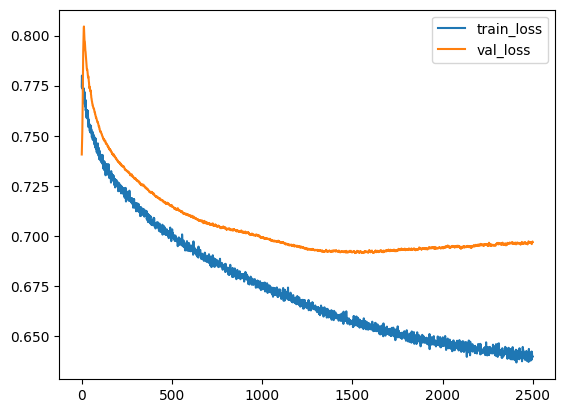

In [208]:
_ = log.plot()

#### Model evaluation

In [209]:
eval_surv = EvalSurv(model.interpolate(20).predict_surv_df(x_test), durations_test, events_test.astype(bool), censor_surv='km')

/home/kuba/.local/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



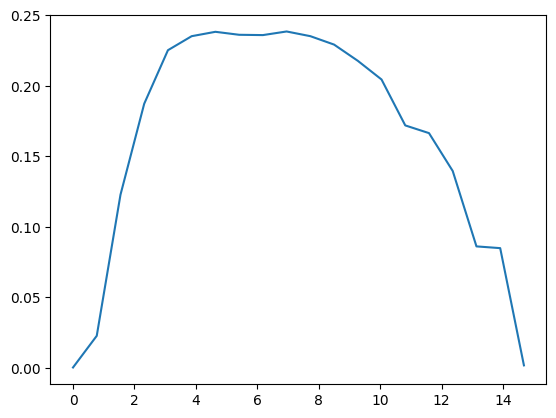

In [210]:
bs = eval_surv.brier_score(model.duration_index)
plt.plot(bs)

In [211]:
ibs = eval_surv.integrated_brier_score(model.duration_index)
f"Integrated Brier score: {ibs}"

'Integrated Brier score: 0.17294972228157623'

#### Model explanation

In [212]:
surv_explainer = SurvivalModelExplainer_(model, x_val, y_val)
ig_explainer = IGExplainer_(model, x_val, y_val)

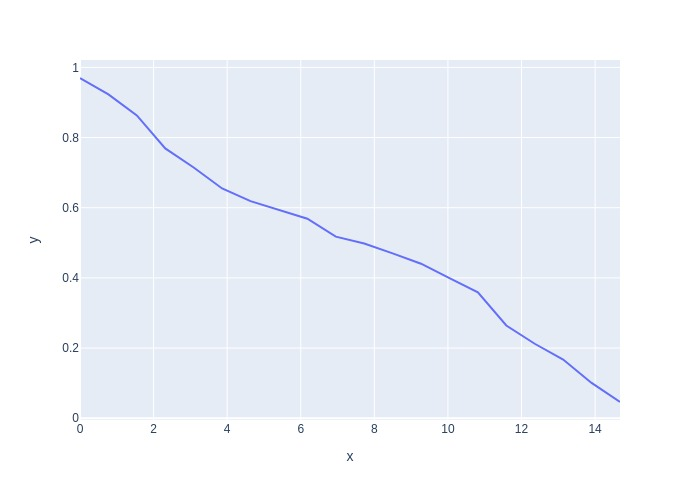

In [213]:
OBS_NUM = 27

model.plot_survival_function(OBS_NUM)

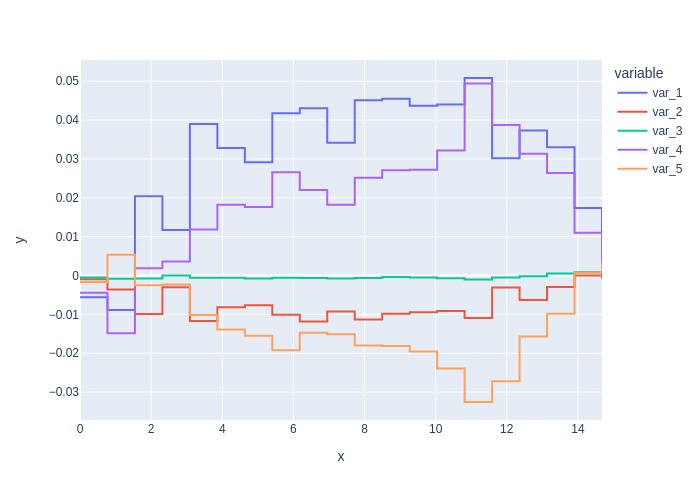

In [214]:
predict_surv = PredictSurvSHAP_()
predict_surv.fit(surv_explainer, OBS_NUM)
predict_surv.get_custom_plot()

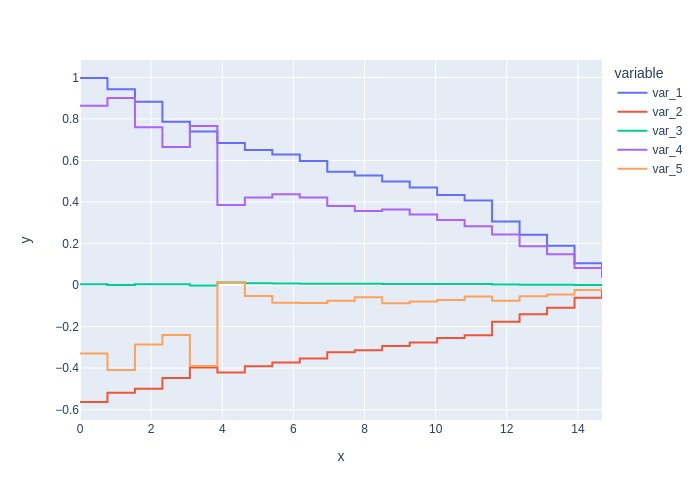

In [215]:
predict_ig = PredictIG_()
predict_ig.fit(ig_explainer, OBS_NUM)
predict_ig.normalize_survival_fn()
predict_ig.get_custom_plot()

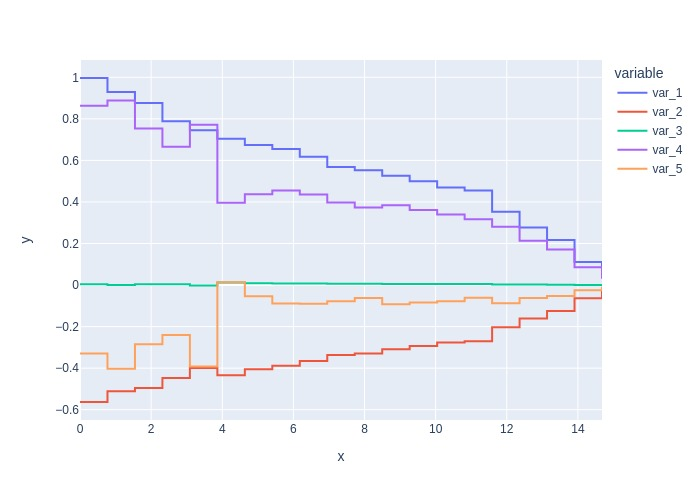

In [216]:
# without normalization
predict_ig = PredictIG_()
predict_ig.fit(ig_explainer, OBS_NUM)
predict_ig.normalize_survival_fn()
predict_ig.get_custom_plot()

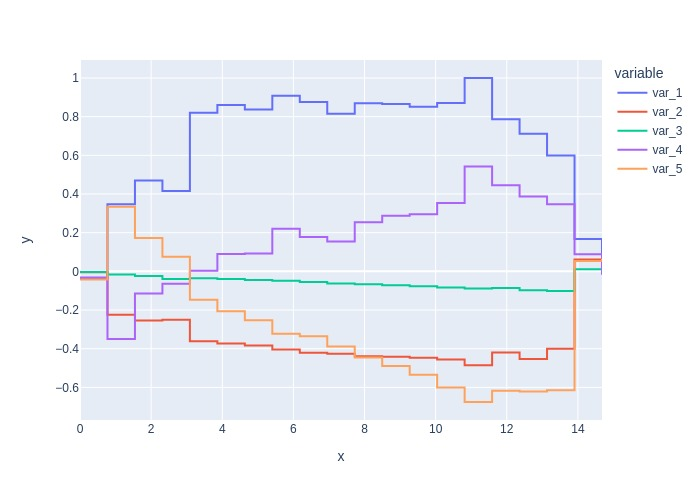

In [217]:
# normalization to get values from [-1, 1]
predict_surv = PredictSurvSHAP_()
predict_surv.fit(surv_explainer, OBS_NUM)
predict_surv.normalize_simple()
predict_surv.get_custom_plot()

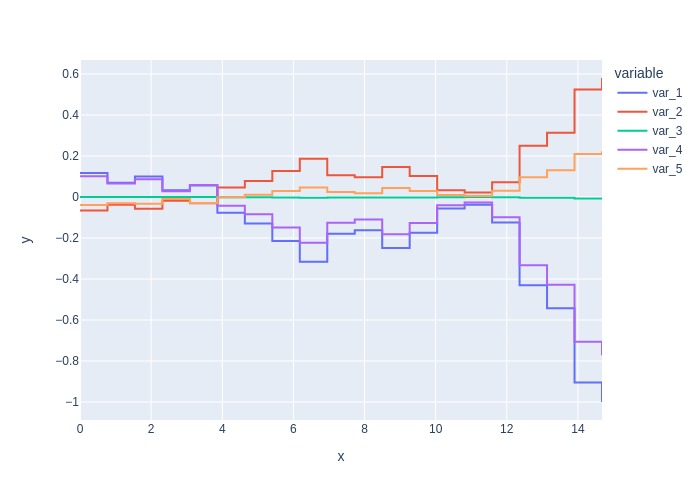

In [218]:
# normalization to get values from [-1, 1]
predict_ig = PredictIG_()
predict_ig.fit(ig_explainer, OBS_NUM)
predict_ig.normalize_simple()
predict_ig.get_custom_plot()

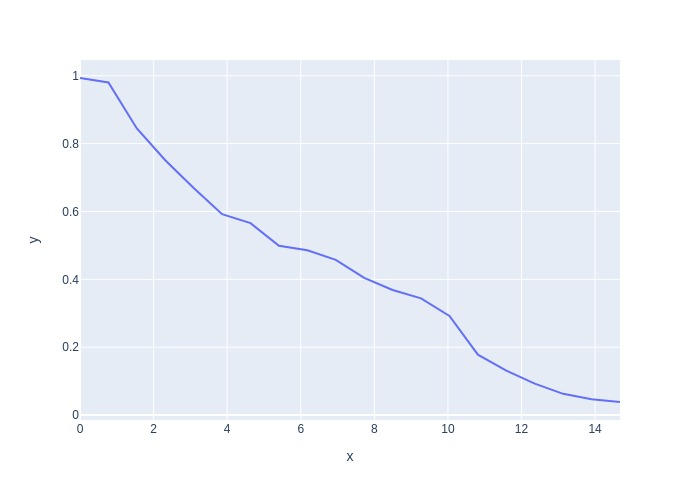

In [219]:
OBS_NUM = 20

model.plot_survival_function(OBS_NUM)

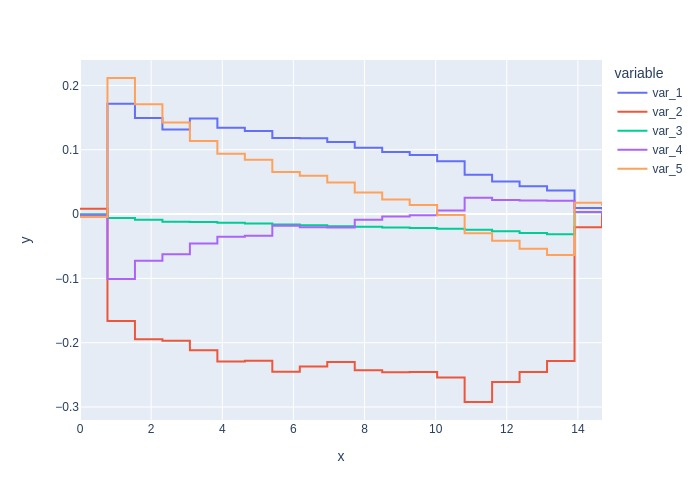

In [220]:
predict_surv = PredictSurvSHAP_()
predict_surv.fit(surv_explainer, OBS_NUM)
predict_surv.get_custom_plot()

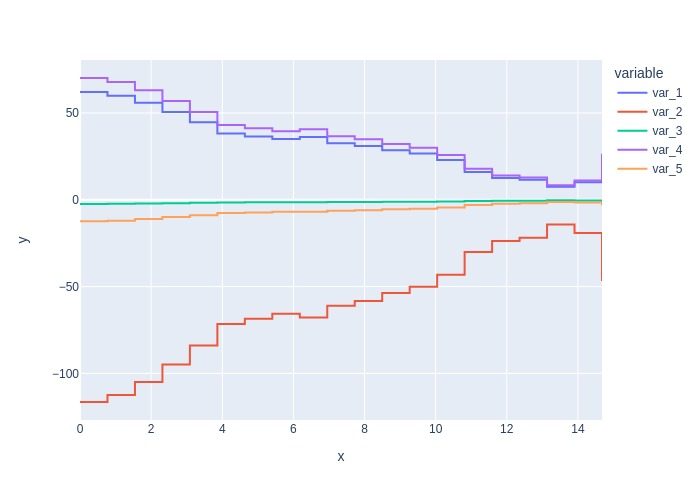

In [221]:
predict_ig = PredictIG_()
predict_ig.fit(ig_explainer, OBS_NUM)
predict_ig.normalize_survival_fn()
predict_ig.get_custom_plot()

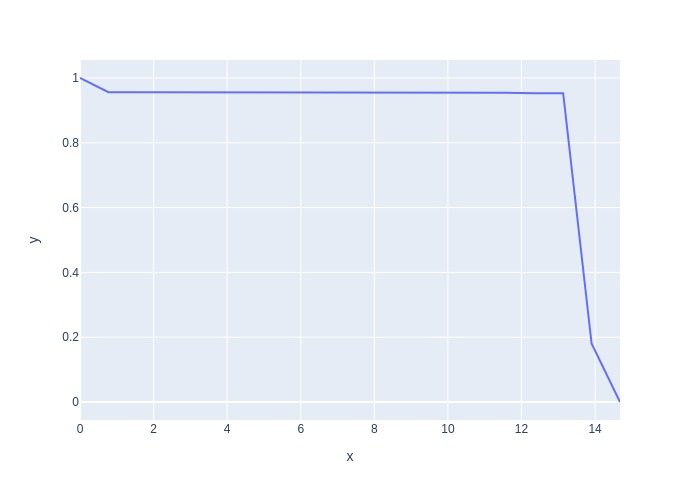

In [222]:
OBS_NUM = 25

model.plot_survival_function(OBS_NUM)

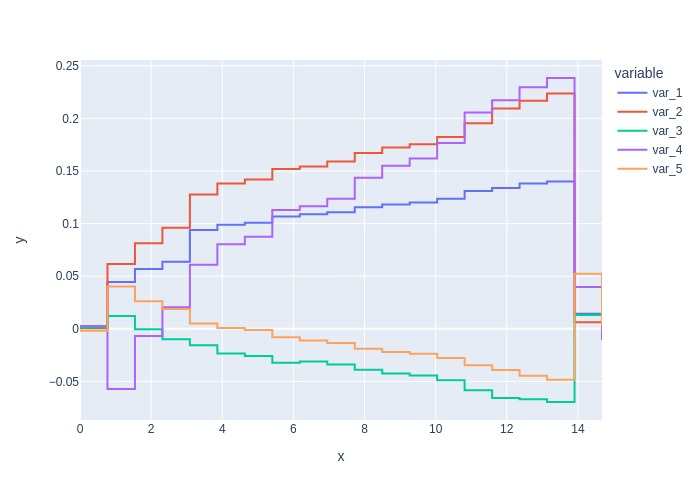

In [223]:
predict_surv = PredictSurvSHAP_()
predict_surv.fit(surv_explainer, OBS_NUM)
predict_surv.get_custom_plot()

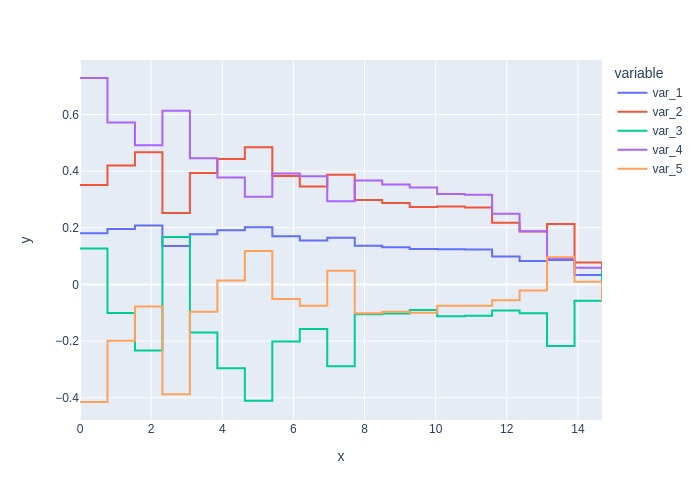

In [224]:
predict_ig = PredictIG_()
predict_ig.fit(ig_explainer, OBS_NUM)
predict_ig.normalize_survival_fn()
predict_ig.get_custom_plot()

### Experiment 2: evaluation on real data

#### Model training

In [225]:
df_train = pd.read_csv("data/exp3_heart_failure_dataset.csv")
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

df_train.head()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4,1
2,65.0,0,146,0,20,0,162000.0,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.0,1.9,137,1,0,7,1
5,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8,1
7,60.0,1,315,1,60,0,454000.0,1.1,131,1,1,10,1


In [226]:
cols_standardize = [
    "age",
    "creatinine_phosphokinase",
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
]
cols_leave = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)


In [227]:
x_train = x_mapper.fit_transform(df_train).astype("float32")
x_val = x_mapper.transform(df_val).astype("float32")
x_test = x_mapper.transform(df_test).astype("float32")


In [228]:
num_durations = 100

labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df["time"].values, df["DEATH_EVENT"].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

x_train.transpose()

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)


In [229]:
in_features = x_train.shape[1]
num_nodes = [4, 4]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.0

net = tt.practical.MLPVanilla(
    in_features, num_nodes, out_features, batch_norm, dropout
).to(torch.device("cpu"))


In [230]:
model = DeepHitSingle_(net, tt.optim.Adam(0.00001), duration_index=labtrans.cuts)

In [231]:
batch_size = 32
epochs = 2000
callbacks = []

train_args = [batch_size, epochs, callbacks]
train_kwargs = {"val_data": val}

In [232]:
log = model.fit(x_train, y_train, *train_args, **train_kwargs)

0:	[0s / 0s],		train_loss: 0.6485,	val_loss: 0.5544
1:	[0s / 0s],		train_loss: 0.6428,	val_loss: 0.5565
2:	[0s / 0s],		train_loss: 0.6472,	val_loss: 0.5589
3:	[0s / 0s],		train_loss: 0.6480,	val_loss: 0.5607
4:	[0s / 0s],		train_loss: 0.6483,	val_loss: 0.5621
5:	[0s / 0s],		train_loss: 0.6442,	val_loss: 0.5626
6:	[0s / 0s],		train_loss: 0.6506,	val_loss: 0.5622
7:	[0s / 0s],		train_loss: 0.6522,	val_loss: 0.5618
8:	[0s / 0s],		train_loss: 0.6455,	val_loss: 0.5614
9:	[0s / 0s],		train_loss: 0.6497,	val_loss: 0.5607
10:	[0s / 0s],		train_loss: 0.6481,	val_loss: 0.5596
11:	[0s / 0s],		train_loss: 0.6453,	val_loss: 0.5595
12:	[0s / 0s],		train_loss: 0.6438,	val_loss: 0.5586
13:	[0s / 0s],		train_loss: 0.6505,	val_loss: 0.5578
14:	[0s / 0s],		train_loss: 0.6455,	val_loss: 0.5581
15:	[0s / 0s],		train_loss: 0.6506,	val_loss: 0.5577
16:	[0s / 0s],		train_loss: 0.6477,	val_loss: 0.5576
17:	[0s / 0s],		train_loss: 0.6532,	val_loss: 0.5574
18:	[0s / 0s],		train_loss: 0.6476,	val_loss: 0.5576
19:

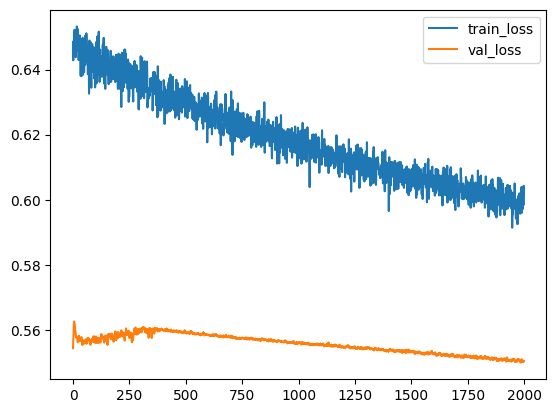

In [233]:
_ = log.plot()


#### Model evaluation

In [234]:
eval_surv = EvalSurv(model.interpolate(20).predict_surv_df(x_test), durations_test, events_test.astype(bool), censor_surv='km')

/home/kuba/.local/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



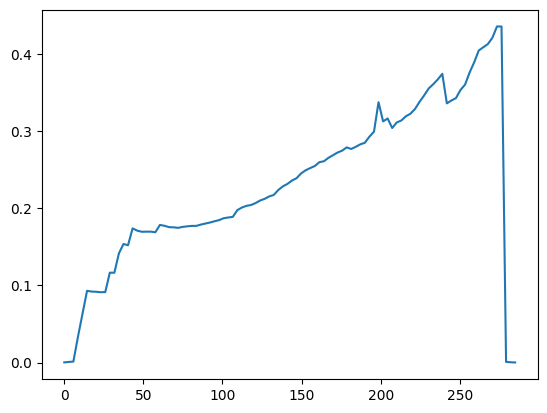

In [235]:
bs = eval_surv.brier_score(model.duration_index)
plt.plot(bs)

In [236]:
ibs = eval_surv.integrated_brier_score(model.duration_index)
f"Integrated Brier score: {ibs}"

'Integrated Brier score: 0.23213473154157702'

#### Model explanation

In [237]:
surv_explainer = SurvivalModelExplainer_(model, x_val, y_val)
ig_explainer = IGExplainer_(model, x_val, y_val)

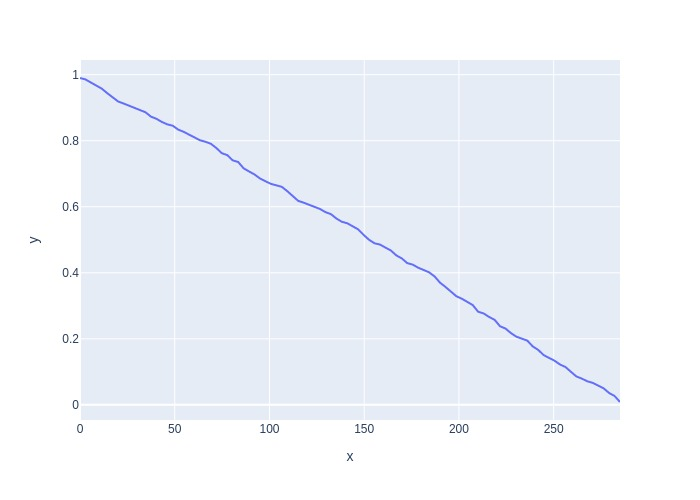

In [238]:
OBS_NUM = 27

model.plot_survival_function(OBS_NUM)

In [239]:
predict_surv = PredictSurvSHAP_()
predict_surv.fit(surv_explainer, OBS_NUM)
predict_surv.get_custom_plot()

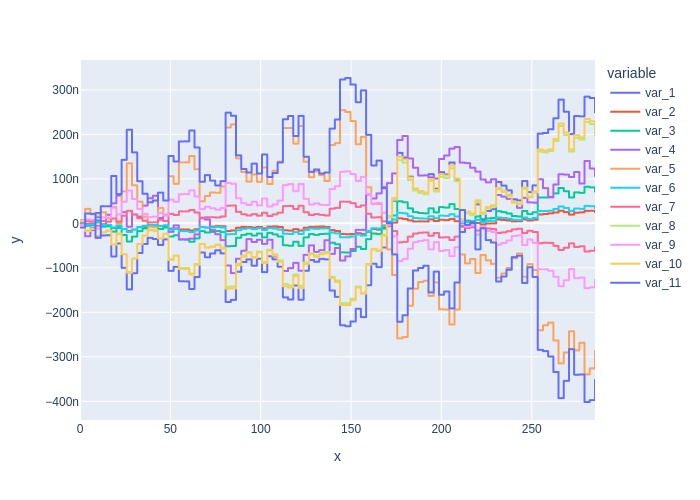

In [ ]:
predict_ig = PredictIG_()
predict_ig.fit(ig_explainer, OBS_NUM)
predict_ig.normalize_survival_fn()
predict_ig.get_custom_plot()

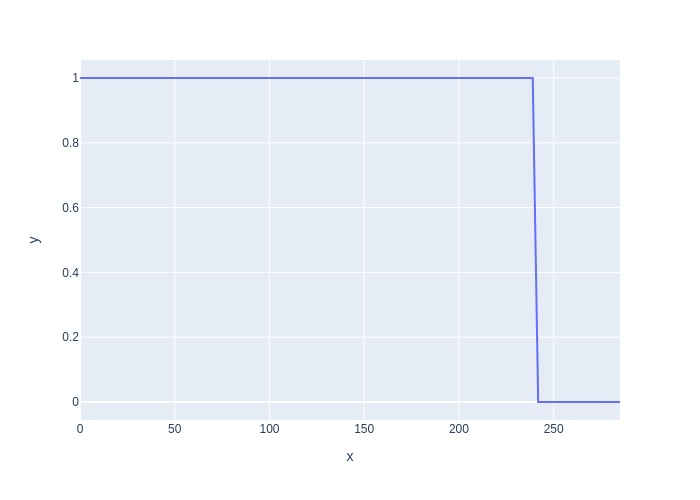

In [ ]:
OBS_NUM = 20

model.plot_survival_function(OBS_NUM)

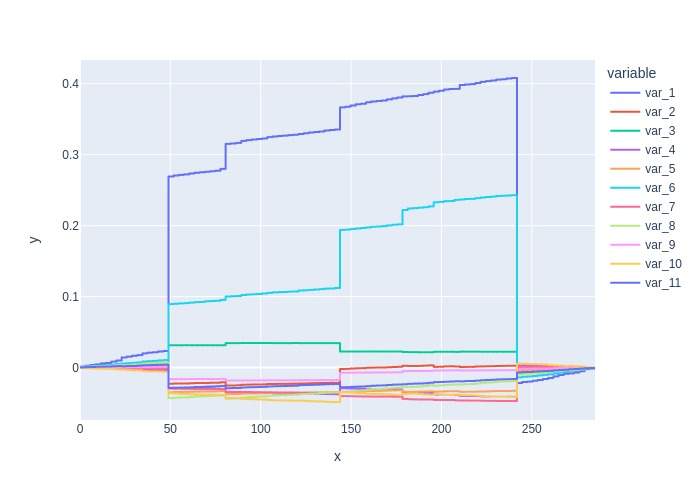

In [ ]:
predict_surv = PredictSurvSHAP_()
predict_surv.fit(surv_explainer, OBS_NUM)
predict_surv.get_custom_plot()

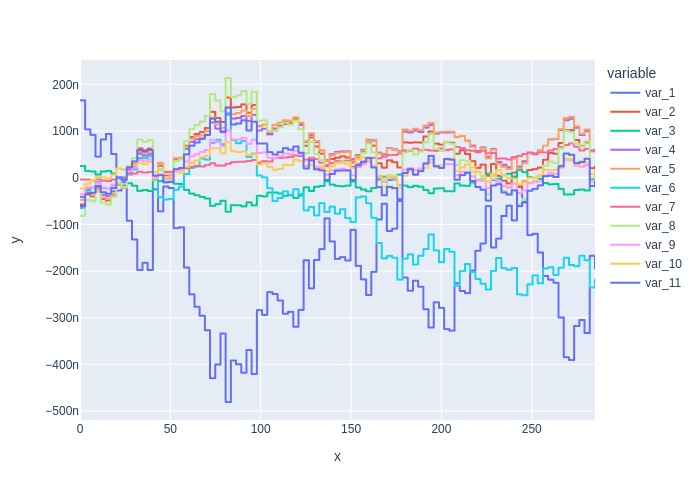

In [ ]:
predict_ig = PredictIG_()
predict_ig.fit(ig_explainer, OBS_NUM)
predict_ig.normalize_survival_fn()
predict_ig.get_custom_plot()

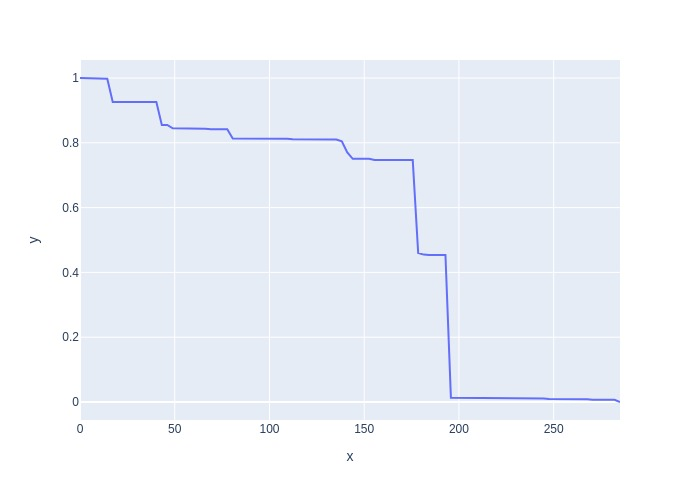

In [ ]:
OBS_NUM = 25

model.plot_survival_function(OBS_NUM)

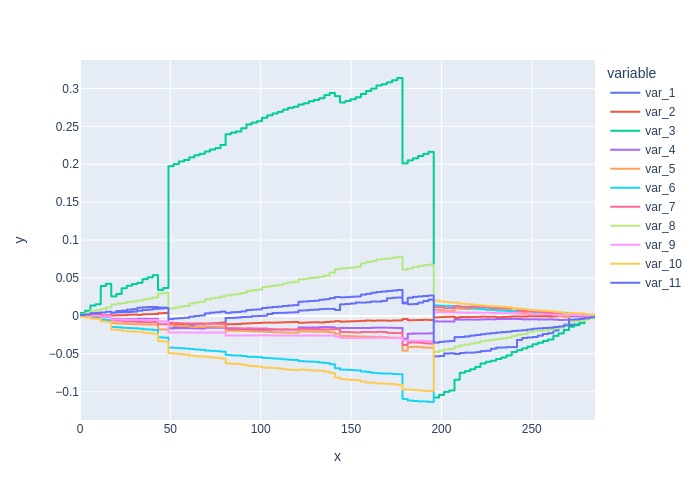

In [ ]:
predict_surv = PredictSurvSHAP_()
predict_surv.fit(surv_explainer, OBS_NUM)
predict_surv.get_custom_plot()

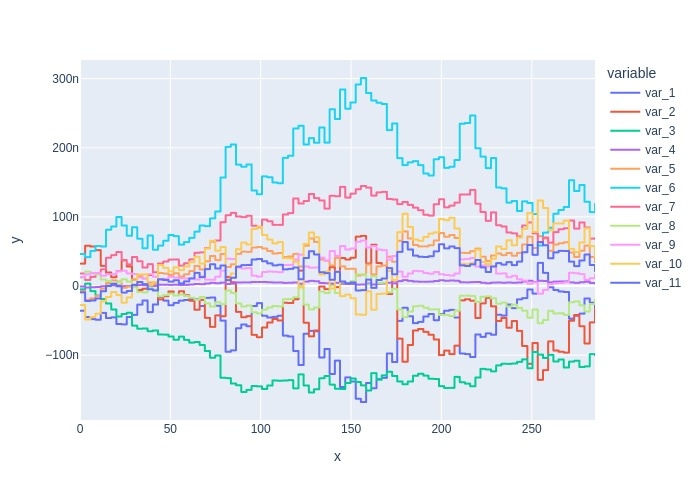

In [ ]:
predict_ig = PredictIG_()
predict_ig.fit(ig_explainer, OBS_NUM)
predict_ig.normalize_survival_fn()
predict_ig.get_custom_plot()